# Explore AuxTel Prompt Processing Subtractions + APDB; BUT using custom reruns
## partially covered in DM-41323
Created by: Neven Caplar \
Started: 2023-10-25 \
Last modified: 2023-11-03 

Goals: Evaluate the quality of prompt processing on auxtel images, with custom reruns

    1. Find the variables in the night sky
        1. a) Create lightcurve from diaSources and evaluate the images
        1. b) Find known variable sources and evaluate how they are detected



In [2]:
# run before notebook the standard invokation: 'source /sdf/group/rubin/sw/loadLSST.bash'
# Note also:
# lsst.analysis.ap not yet in lsst distrib, just a data managment (dm) package
# so github clone from https://github.com/lsst/analysis_ap
# and add to your notebooks/.user_setups the following line
# setup -k -r <PATH_To_Directory>/analysis_ap

import numpy as np
import pandas as pd

# astropy imports
import astropy.units as u
from astropy.io import fits
from astropy.time import Time
from astropy.visualization.stretch import SinhStretch, LinearStretch, AsinhStretch
from astropy.visualization import ImageNormalize
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord

# warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [3]:
# AP LSST import
from lsst.analysis.ap import apdb, CutoutPath
from lsst.ap.association import UnpackApdbFlags

# all of the other lsst imports
import lsst.afw.display as afwDisplay
import lsst.daf.butler as dafButler
import lsst.geom as geom
from lsst.analysis.tools.actions.vector import ConvertUnits, FlagSelector, GoodDiaSourceSelector, LoadVector
from lsst.analysis.tools.atools import SkySourceHistPlot, SkySourceSkyPlot, NumDiaSourcesAllMetric, NumDiaSourcesMetric, NumDipolesMetric
from lsst.daf.butler import DataCoordinate
# Specific Dimension Packer 
from lsst.obs.lsst import RubinDimensionPacker
from lsst.utils import getPackageDir

# Visualization packages
import matplotlib.pyplot as plt
from IPython.display import Image, display
afwDisplay.setDefaultBackend('matplotlib')
%matplotlib inline

In [4]:
# just to check what it the status of analysis_ap import
!eups list analysis_ap
!git status

   LOCAL:/home/n/ncaplar/github/analysis_ap 	setup
On branch u/ncaplar/APDB_explore
Your branch is up to date with 'origin/u/ncaplar/APDB_explore'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   use_APDB_for_auxtel.ipynb
	modified:   use_custom_APDB_for_auxtel.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	Untitled1.ipynb
	Untitled2.ipynb
	Untitled3.ipynb
	Untitled4.ipynb
	bps_report.png
	use_APDB_for_auxtel_40791.ipynb
	use_APDB_for_auxtel_DM_41323.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [5]:
repo = "/sdf/group/rubin/repo/embargo/"
butler = dafButler.Butler(repo)

# Which collection are avaliable from prompt processing
# The information from this query can be also found here:
# https://confluence.lsstcorp.org/display/DM/Prompt+Processing+with+AuxTel+Imaging+Survey+Data+2023
butler_query = ! butler query-collections /sdf/group/rubin/repo/embargo "LATISS/prompt/*-2023-*/ApPipe/*"
butler_query

['                               Name                               Type',
 '----------------------------------------------------------------- ----',
 'LATISS/prompt/output-2023-05-24/ApPipe/prompt-proto-service-00026 RUN ',
 'LATISS/prompt/output-2023-05-25/ApPipe/prompt-proto-service-00027 RUN ',
 'LATISS/prompt/output-2023-07-20/ApPipe/prompt-proto-service-00007 RUN ',
 'LATISS/prompt/output-2023-08-15/ApPipe/prompt-proto-service-00010 RUN ',
 'LATISS/prompt/output-2023-08-16/ApPipe/prompt-proto-service-00011 RUN ',
 'LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011 RUN ',
 'LATISS/prompt/output-2023-08-29/ApPipe/prompt-proto-service-00013 RUN ']

In [6]:
# Which collection are avaliable from custom reruns
# The command that created this collection is found in the ticket
# Let us concentrate on November 01 run with weekly 43 
# earlier runs were testing runs or did not complete fully
# Note that these runs do not include results of DRP Latiss sprint in October 2023
butler_query_custom =! butler query-collections /sdf/group/rubin/repo/embargo "u/ncaplar/DM-41323/20231101*"
butler_query_custom

['                Name                Type',
 '----------------------------------- ----',
 'u/ncaplar/DM-41323/20231101T192110Z RUN ']

In [113]:
def find_products(diaSourceId_table, diaSourceId):
    """
    Helper function to find products from the original prompt processing

    Inputs
    ----------------

    Outputs
    ----------------
    
    
    Notes
    ----------------
    
    This substitutes the workflow such as
    
    ! butler query-datasets /sdf/group/rubin/repo/embargo \
    --collections "LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011" \
    --where "instrument='LATISS' and detector=0 and band='g' and visit >= 2023081700470 and visit <= 2023081700470" \
    deepDiff_differenceExp
    """
    
    
    source_row = diaSourceId_table[diaSourceId_table['diaSourceId'] == diaSourceId]
    if source_row.shape[0] != 1:
        # Add a custom comment here
        raise AssertionError("One and only one diaSource has to be in the diaSource table")

    # Start with the time in modified julian date (MJD)
    mjd = source_row['midpointMjdTai']
    # Convert to Julian Date
    jd = mjd + 2400000.5

    # Convert to astropy Time object
    t = Time(jd, format='jd')
    # subtract half a day to get when the run started
    start_t= t - 0.5 * u.day
    # Convert to datetime
    target_time = start_t.to_value('iso', subfmt='date')[0]
    print(target_time)
    # butler_query not defined
    for item in list(butler_query):
        if target_time in item:
            print("Found a match in butler!")
            # to remove " RUN" at the end of the string
            # quite clumsy and fragile
            collection_name = item[:-5]
    
    ap_collection = collection_name
    data_id = {"instrument": "LATISS", "detector": 0, "band": source_row['band'].values[0], "visit": int(source_row['visit'].values)}

    calexp = butler.get("calexp", dataId=data_id, collections=ap_collection)
    diff = butler.get("deepDiff_differenceExp", dataId=data_id, collections=ap_collection)
    template = butler.get("deepDiff_templateExp", dataId=data_id, collections=ap_collection)
    matched_template = butler.get("deepDiff_matchedExp", dataId=data_id, collections=ap_collection)

    # Includes detections and sky sources. Direct output from detect+measure after image subtraction.
    diaSrc = butler.get("deepDiff_diaSrc", dataId=data_id, collections=ap_collection)
    # The SDM/DPDD (Science Data Model/Data Products Definition Document) version of the diaSrc Table. No sky sources.  Flags are packed into uint64.
    diaSrcTable = butler.get("deepDiff_diaSrcTable", dataId=data_id, collections=ap_collection)
    
    return calexp, diff, template, matched_template, diaSrc, diaSrcTable

In [114]:
def show_cutout_triplet(template, science, diff, x, y, size=30, figsize=(16, 8), vmin_strech = 0.01, vmax_strech = 0.99):
    """
    Create and show a cutout of an template, science and difference image
    given a position
    """
    xy = geom.PointI(x, y)
    cutoutSize = geom.ExtentI(size, size)
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    
    assert template.getDimensions() == science.getDimensions() == diff.getDimensions()
    
    # clipping to the dimension of the image; prevents clipping outside of the image 
    bbox = bbox.clippedTo(template.getBBox())
    print(x, y, bbox)
    template_cutout = template.getCutout(bbox)
    science_cutout = science.getCutout(bbox)
    diff_cutout = diff.getCutout(bbox)

    # Use diff sigma for calexp, diff ranges.
    sigma = np.sqrt(np.median(diff.variance.array))

    fit, axes = plt.subplots(1, 3, figsize=figsize)
    plt.sca(axes[0])
    
    stretch =  AsinhStretch() 
    norm = ImageNormalize(stretch=stretch, vmin=np.quantile(template_cutout.image.array,0.01), vmax=np.quantile(template_cutout.image.array,vmax_strech))
    plt.imshow(template_cutout.image.array, cmap="gray", norm=norm, origin='lower')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("Template")
    plt.sca(axes[1])
    plt.imshow(science_cutout.image.array, cmap="gray", norm=norm, origin='lower')
    plt.title("Science")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.sca(axes[2])
    plt.imshow(diff_cutout.image.array, cmap="gray", vmin=-3*sigma, vmax=+3*sigma, origin='lower')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("Diff")

# Test run

In [115]:
"""
source /sdf/group/rubin/sw/loadLSST.bash
setup lsst_distrib

pipetask run -b /repo/embargo -i LATISS/defaults,LATISS/templates  -o u/ncaplar/test  -d  "detector=0  and instrument='LATISS' and exposure=2023072000340 and visit_system=0"  -p $AP_PIPE_DIR/pipelines/LATISS/ApPipe.yaml -c parameters:coaddName=deep -c diaPipe:apdb.db_url=sqlite://///sdf/home/n/ncaplar/rubin-user/apdb.db

SyntaxError: incomplete input (45760237.py, line 1)

In [131]:
repo = "/sdf/group/rubin/repo/embargo/"
butler = dafButler.Butler(repo)
schema = 'pp_apdb'
instrument = 'LATISS'

apdbQuery = apdb.ApdbPostgresQuery(schema, url="rubin@usdf-prompt-processing.slac.stanford.edu/lsst-devl",\
                                   butler=butler, instrument=instrument)
schema = 'ncaplar_dm_41323'
apdbQuery_custom = apdb.ApdbPostgresQuery(schema, url="rubin@usdf-prompt-processing-dev.slac.stanford.edu/lsst-devl",\
                                   butler=butler, instrument=instrument)
"""
apdbQuery_custom = apdb.ApdbSqliteQuery(filename = '/home/n/ncaplar/rubin-user/apdb.db',\
                                   butler=butler, instrument=instrument)
"""

OperationalError: (psycopg2.OperationalError) connection to server at "usdf-prompt-processing-dev.slac.stanford.edu" (172.24.5.177), port 5432 failed: FATAL:  server login has been failing, try again later (server_login_retry)
connection to server at "usdf-prompt-processing-dev.slac.stanford.edu" (172.24.5.177), port 5432 failed: FATAL:  server login has been failing, try again later (server_login_retry)

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [117]:
sources = apdbQuery.load_sources(exclude_flagged=True)
# we now make a reduced dataframe, with only columns that are of interest to us
sources_cortado = sources[['diaSourceId','diaObjectId','ra','dec','x','y','midpointMjdTai','psfFlux','psfFluxErr','scienceFlux','scienceFluxErr','snr', 'band','flags','visit']]

sources_custom = apdbQuery_custom.load_sources(exclude_flagged = True)
sources_custom_cortado = sources_custom[['diaSourceId','diaObjectId','ra','dec','x','y','midpointMjdTai','psfFlux','psfFluxErr','scienceFlux','scienceFluxErr','snr', 'band','flags','visit']]



In [118]:
np.unique(sources_custom_cortado['visit'])

array([2023052400710, 2023052400711, 2023072000340, 2023082900379,
       2023082900428, 2023082900463, 2023082900495])

5929    1469.78186
Name: x, dtype: float64 5929    771.816711
Name: y, dtype: float64 (minimum=(1404, 706), maximum=(1533, 835))


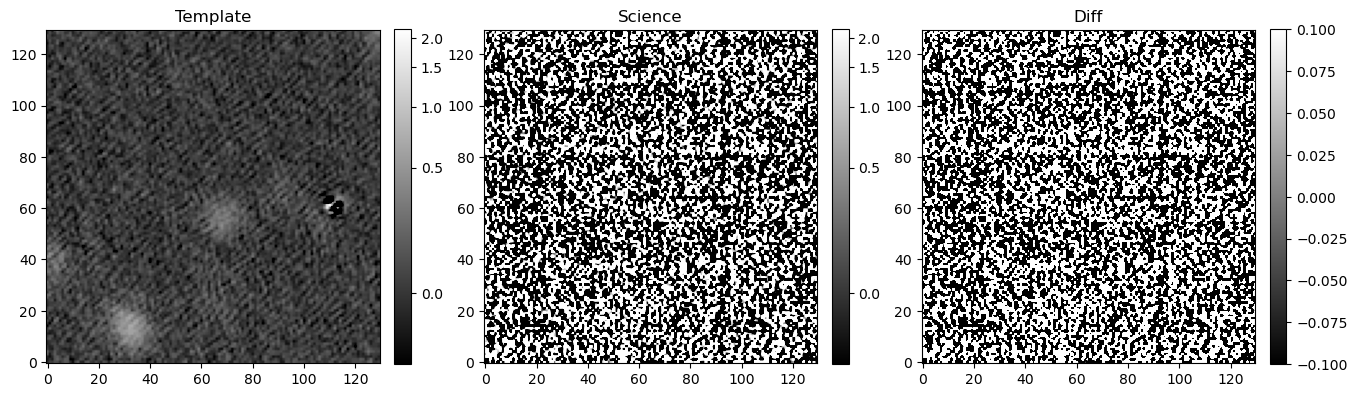

In [119]:
stamp_size = 30 # pixels.  Size of baseline alert stamp
stamp_size = 130 # pixels.  Bigger stamp to see more detail
x = single_diaSource['x']
y = single_diaSource['y']

show_cutout_triplet(matched_template, calexp, diff, x, y, size=stamp_size, vmin_strech=0.1, vmax_strech = 1)

In [120]:
diaSourceId = 174092638167761442
calexp, diff, template, matched_template, diaSrc, diaSrcTable = find_products(sources, diaSourceId)
single_diaSource = sources_cortado[sources_cortado['diaSourceId'] == diaSourceId]
visit_single_diaSource = single_diaSource['visit'].values[0]

sources_single_visit = sources[sources['visit'] == visit_single_diaSource]

2023-07-20
Found a match in butler!


In [121]:
ap_collection = 'u/ncaplar/test/20231026T184927Z'
data_id = {"instrument": "LATISS", "detector": 0, "band": single_diaSource['band'].values[0], "visit": int(2023072000340)}

calexp_custom = butler.get("calexp", dataId=data_id, collections=ap_collection)
diff_custom = butler.get("deepDiff_differenceExp", dataId=data_id, collections=ap_collection)
template_custom = butler.get("deepDiff_templateExp", dataId=data_id, collections=ap_collection)
matched_template_custom = butler.get("deepDiff_matchedExp", dataId=data_id, collections=ap_collection)

# Includes detections and sky sources. Direct output from detect+measure after image subtraction.
diaSrc_custom = butler.get("deepDiff_diaSrc", dataId=data_id, collections=ap_collection)
# The SDM/DPDD (Science Data Model/Data Products Definition Document) version of the diaSrc Table. No sky sources.  Flags are packed into uint64.
diaSrcTable_custom = butler.get("deepDiff_diaSrcTable", dataId=data_id, collections=ap_collection)

single_diaSource_custom = sources_custom_cortado[sources_custom_cortado['diaSourceId'] == diaSourceId]

sources_custom_single_visit = sources_custom_cortado[sources_custom_cortado['visit'] == 2023072000340]

In [122]:
sources_custom_single_visit

,diaSourceId,diaObjectId,ra,dec,x,y,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,snr,band,flags,visit
259,174092638167761079,174092638167761079,270.217016,-25.013189,3864.229004,58.490421,60146.200627,396965.717908,66026.372173,2.892260e+05,98908.034994,5.790901,r,0,2023072000340
260,174092638167761080,174092638167761080,270.151814,-25.013393,1641.446167,79.526573,60146.200627,444053.595333,83736.740228,4.499021e+05,104642.531823,5.440089,r,0,2023072000340
261,174092638167761082,174092638167761082,270.209894,-25.013233,3621.423096,60.051788,60146.200627,364695.260218,66133.641359,2.854803e+05,97994.992128,5.258779,r,0,2023072000340
262,174092638167761084,174092638167761084,270.214705,-25.009978,3787.029541,180.307968,60146.200627,347390.065978,67806.558605,2.489490e+05,98924.800603,5.133223,r,0,2023072000340
263,174092638167761086,174092638167761086,270.209869,-25.008683,3622.820801,231.172409,60146.200627,386048.631443,67788.919011,3.015666e+05,97365.760427,5.590491,r,0,2023072000340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,174092638167761227,174092638167761227,270.178413,-24.910252,2598.705162,3947.517255,60146.200627,-499756.721829,131966.868002,2.209656e+07,211102.990853,8.818157,r,0,2023072000340
325,174092638167761228,174092638167761228,270.165177,-24.910208,2147.157715,3954.993652,60146.200627,520893.731575,81738.061668,3.595845e+05,89618.147179,6.251646,r,0,2023072000340
326,174092638167761229,174092638167761229,270.216072,-24.909706,3883.800781,3951.374023,60146.200627,408900.315125,82452.285935,2.307806e+05,84517.238830,5.183671,r,0,2023072000340
327,174092638167761231,174092638167761231,270.183651,-24.910072,2777.505859,3952.015625,60146.200627,401279.743707,82205.827807,2.575440e+05,89088.538633,5.169572,r,0,2023072000340


5929    1469.78186
Name: x, dtype: float64 5929    771.816711
Name: y, dtype: float64 (minimum=(1404, 706), maximum=(1533, 835))


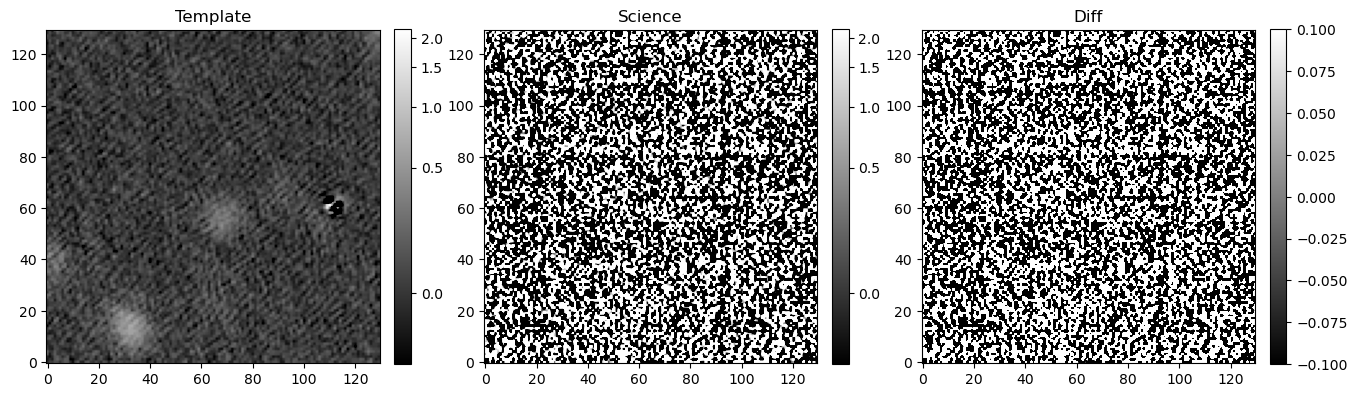

In [123]:
stamp_size = 30 # pixels.  Size of baseline alert stamp
stamp_size = 130 # pixels.  Bigger stamp to see more detail
x = single_diaSource['x']
y = single_diaSource['y']

show_cutout_triplet(matched_template, calexp, diff, x, y, size=stamp_size, vmin_strech=0.1, vmax_strech = 1)

5929    1469.78186
Name: x, dtype: float64 5929    771.816711
Name: y, dtype: float64 (minimum=(1404, 706), maximum=(1533, 835))


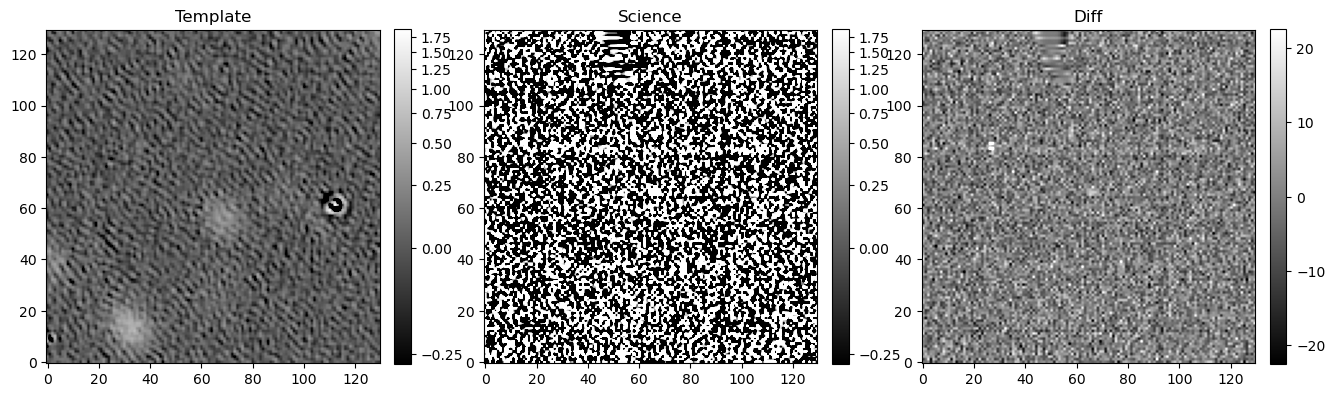

In [124]:
stamp_size = 30 # pixels.  Size of baseline alert stamp
stamp_size = 130 # pixels.  Bigger stamp to see more detail
x = single_diaSource['x']
y = single_diaSource['y']

show_cutout_triplet(matched_template_custom, calexp_custom, diff_custom, x, y, size=stamp_size, vmin_strech=0.1, vmax_strech = 1)

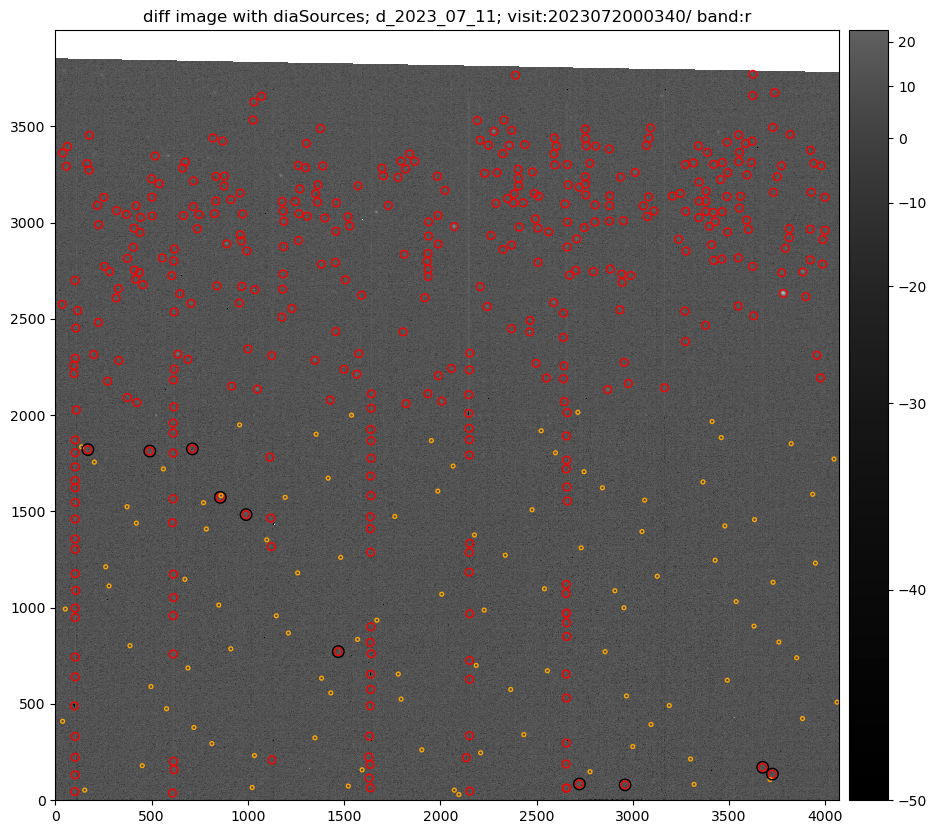

In [125]:
fig = plt.figure(figsize=(16, 10))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(diff.image)
with display.Buffering():
    for s in diaSrc:
        if s['sky_source']:
            display.dot("o", s.getX(), s.getY(), size=10, ctype="orange")
        else:
            display.dot("o", s.getX(), s.getY(), size=20, ctype="red")
    for index, row in sources_single_visit[['x','y']].iterrows():
        display.dot("o", row['x'], row['y'], size=30, ctype="black")

plt.title('diff image with diaSources; d_2023_07_11; visit:' + str(single_diaSource['visit'].values[0]) + '/ band:'+str(single_diaSource['band'].values[0]))
plt.show()

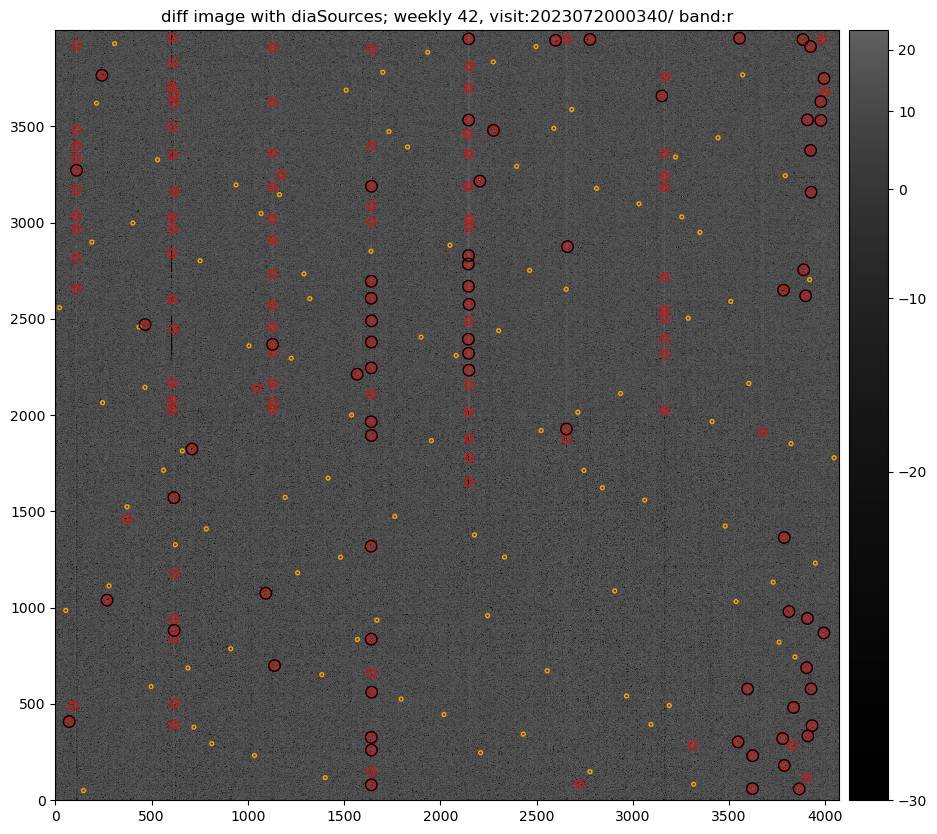

In [126]:
fig = plt.figure(figsize=(16, 10))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(diff_custom.image)
with display.Buffering():
    for s in diaSrc_custom:
        if s['sky_source']:
            display.dot("o", s.getX(), s.getY(), size=10, ctype="orange")
        else:
            display.dot("o", s.getX(), s.getY(), size=20, ctype="red")
    for index, row in sources_custom_single_visit[['x','y']].iterrows():
        display.dot("o", row['x'], row['y'], size=30, ctype="black")

plt.title('diff image with diaSources; weekly 42, visit:' + str(single_diaSource['visit'].values[0]) + '/ band:'+str(single_diaSource['band'].values[0]))
plt.show()